# Ford GoBike System Data
## by Robert Grütze


## Table of Contents

<ul>
<li><a href="#intro">Intro</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#univariate">Univariate Exploration</a></li>
<li><a href="#bivariate">Bivariate Exploration</a></li>
<li><a href="#multivariate">Multivariate Exploration</a></li>
</ul>

<a id='intro'></a>
## 1. Intro

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

> Each trip is anonymized and includes:

- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)

**Following questions will be adressed in this notebook:**
> *When are most trips taken in terms of time of day, day of the week, or month of the year?*

> *How long does the average trip take?*

> *Does the above depend on if a user is a subscriber or customer?*

> *Which bike IDs were used in particular and which not?*

> *Are there any special patterns regading the renting behaviour to be observed?*

> *What changed in the behaviour when the biking rental was rebranded to lyft?*

<a id='wrangling'></a>
## 2. Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests, zipfile
import re
import os 
import calendar
import math

%matplotlib inline

### Gather Data

In [2]:
# gather 2017 data

# unzip files in order to handle filesize limitations in git
with zipfile.ZipFile("data/2017-fordgobike-tripdata.csv.zip") as z:
    # load dataset from data subir
    with z.open("2017-fordgobike-tripdata.csv") as f:
        df_2017 = pd.read_csv(f)

In [3]:
# gather 2019 data

# gather img predictions by downloading image-predictions.tsv  to /data
url_ford = 'https://s3.amazonaws.com/baywheels-data/2019{:02d}-fordgobike-tripdata.csv.zip'
url_baywheels = 'https://s3.amazonaws.com/baywheels-data/2019{:02d}-baywheels-tripdata.csv.zip'

df_list = list()
switch_idx = 4


# loop through each monthly file
for idx in range(12):
    
    # replace url string
    if idx < switch_idx:
        url_tem = url_ford.format(idx+1)
    else:
        url_tem = url_baywheels.format(idx+1)
        
    # send request
    response = requests.get(url_tem)
    with open(url_tem.split('/')[-1], mode = 'wb') as outfile:
        
        # load data
        source = url_tem.split('/')[-1]
        destination = os.path.join('data', source)
        outfile.write(response.content)
        os.rename(source, destination)
        
        # extract data
        with zipfile.ZipFile(destination) as z:
            with z.open(source[:-4]) as f:
                df_tem = pd.read_csv(f)
                if idx < switch_idx:
                    df_list.append(df_tem)
                else:
                    df_list.append(df_tem)


/Users/robert/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/robert/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/robert/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# concat monthly dataframe to yearly one
df_2019 = []
df_2019 = pd.concat(df_list, axis=0, sort=False)
df_2019.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
0,80825,2019-01-31 17:57:44.6130,2019-02-01 16:24:49.8640,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,No,NaN
1,65900,2019-01-31 20:58:33.8860,2019-02-01 15:16:54.1730,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,No,NaN
2,62633,2019-01-31 18:06:52.9240,2019-02-01 11:30:46.5300,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,No,NaN
3,44680,2019-01-31 19:46:09.7190,2019-02-01 08:10:50.3180,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,No,NaN
4,60709,2019-01-31 14:19:01.5410,2019-02-01 07:10:51.0650,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,-122.388098,2100,Customer,No,NaN


In [5]:
# rename dataset
df = df_2019

### Assess Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2506983 entries, 0 to 150101
Data columns (total 15 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
bike_share_for_all_trip    object
rental_access_method       object
dtypes: float64(6), int64(2), object(7)
memory usage: 306.0+ MB


In [7]:
df.shape

(2506983, 15)

In [8]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,rental_access_method
0,80825,2019-01-31 17:57:44.6130,2019-02-01 16:24:49.8640,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,No,NaN
1,65900,2019-01-31 20:58:33.8860,2019-02-01 15:16:54.1730,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,No,NaN
2,62633,2019-01-31 18:06:52.9240,2019-02-01 11:30:46.5300,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,No,NaN
3,44680,2019-01-31 19:46:09.7190,2019-02-01 08:10:50.3180,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,No,NaN
4,60709,2019-01-31 14:19:01.5410,2019-02-01 07:10:51.0650,16.0,Steuart St at Market St,37.794130,-122.394430,28.0,The Embarcadero at Bryant St,37.787168,-122.388098,2100,Customer,No,NaN


In [9]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id
count,2.506983e+06,2.426249e+06,2.506983e+06,2.506983e+06,2.424081e+06,2.506983e+06,2.506983e+06,2.506983e+06
mean,8.076483e+02,1.465047e+02,3.776506e+01,-1.223499e+02,1.427044e+02,3.776422e+01,-1.223459e+02,2.789833e+04
std,1.974714e+03,1.223171e+02,1.363698e-01,3.089648e-01,1.214296e+02,2.392885e-01,7.080417e-01,1.146067e+05
min,6.000000e+01,3.000000e+00,0.000000e+00,-1.225143e+02,3.000000e+00,0.000000e+00,-1.225143e+02,4.000000e+00
25%,3.590000e+02,4.700000e+01,3.776931e+01,-1.224130e+02,4.300000e+01,3.777003e+01,-1.224117e+02,1.952000e+03
50%,5.710000e+02,1.050000e+02,3.778053e+01,-1.223983e+02,1.010000e+02,3.778076e+01,-1.223981e+02,4.420000e+03
75%,8.870000e+02,2.430000e+02,3.779539e+01,-1.222914e+02,2.390000e+02,3.779587e+01,-1.222934e+02,9.682000e+03
max,9.121100e+05,4.980000e+02,4.551000e+01,0.000000e+00,4.980000e+02,4.551000e+01,0.000000e+00,9.999410e+05


In [10]:
df.duplicated().sum()

0

In [11]:
df.isnull().sum()


duration_sec                     0
start_time                       0
end_time                         0
start_station_id             80734
start_station_name           80133
start_station_latitude           0
start_station_longitude          0
end_station_id               82902
end_station_name             82350
end_station_latitude             0
end_station_longitude            0
bike_id                          0
user_type                        0
bike_share_for_all_trip     243259
rental_access_method       2386145
dtype: int64

In [12]:
df.dtypes

duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
bike_share_for_all_trip     object
rental_access_method        object
dtype: object

**observed quality and titiness issues with dataset**
- format of *start_time* and *end_time* is not datetime
- any id should be stored as a string
- drop rows with null values 
- drop unused columns bike_share_for_all_trip, rental_access_method

**wanted features to be obtained from the dataset**
- distance of individual rides
- extract *day*, *day of the week* and *month of the year*


### Clean Data 

**Define**:
    - drop unused columns
    - drop rows with null values

In [13]:
# columns
df.drop(['rental_access_method', 'bike_share_for_all_trip'], axis=1, inplace=True)

# nulls
df.dropna(inplace=True)


**Define**:
    - fix column format

In [14]:
# fix IDs as string
df.start_station_id = df.start_station_id.astype(str)
df.end_station_id   = df.end_station_id.astype(str)
df.bike_id          = df.bike_id.astype(str)


# fix time columns
#df['start_time'] = pd.to_datetime(df['start_time'].dt.date)
#df['end_time']   = pd.to_datetime(df['end_time'].dt.date)

df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time']   = pd.to_datetime(df['end_time'])

**Define**:
    - extract Monute/Hour/Day/Weekday/Month/Year in seperate columns

In [15]:
# hour
df['start_time_hour'] = df['start_time'].dt.hour
df['end_time_hour']   = df['end_time'].dt.hour

In [16]:
# week
df['start_time_weekday'] = df['start_time'].dt.weekday_name
df['end_time_weekday']   = df['end_time'].dt.weekday_name

df['start_time_weekday'] = df['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df['end_time_weekday']   = df['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

In [17]:
# month
df['start_time_month'] = df['start_time'].dt.month.astype(int)
df['end_time_month']   = df['end_time'].dt.month.astype(int)

In [18]:
# year
df['start_time_year']  = df['start_time'].dt.year.astype(int)
df['end_time_year']    = df['end_time'].dt.year.astype(int)


In [19]:
df.head()
df.tail()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,start_time_hour,end_time_hour,start_time_weekday,end_time_weekday,start_time_month,end_time_month,start_time_year,end_time_year
149775,853,2019-12-30 10:10:18,2019-12-30 10:24:31,6.0,The Embarcadero at Sansome St,37.80477,-122.403234,5.0,Powell St BART Station (Market St at 5th St),37.783899,...,104326,Subscriber,10,10,Mon,Mon,12,12,2019,2019
149776,385,2019-12-19 16:33:10,2019-12-19 16:39:35,6.0,The Embarcadero at Sansome St,37.80477,-122.403234,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,...,829584,Subscriber,16,16,Thu,Thu,12,12,2019,2019
149777,1581,2019-12-31 20:16:15,2019-12-31 20:42:37,6.0,The Embarcadero at Sansome St,37.80477,-122.403234,50.0,2nd St at Townsend St,37.780526,...,882336,Subscriber,20,20,Tue,Tue,12,12,2019,2019
149778,1719,2019-12-31 10:58:30,2019-12-31 11:27:10,6.0,The Embarcadero at Sansome St,37.80477,-122.403234,371.0,Lombard St at Columbus Ave,37.802746,...,655789,Subscriber,10,11,Tue,Tue,12,12,2019,2019
149779,368,2019-12-23 17:13:43,2019-12-23 17:19:52,6.0,The Embarcadero at Sansome St,37.80477,-122.403234,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,...,119878,Subscriber,17,17,Mon,Mon,12,12,2019,2019


In [20]:
df.shape

(2407259, 21)

**Define**:
- get distance between start and endpoint

*using proposed solution from:* 
https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

In [21]:
def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [22]:
# get distance in km
df['distance_km'] = df.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)




In [27]:
# reindex data
df.reindex()

# store master data
df.to_csv('result/gobike2019_master.csv', index = False)

### What is the structure of your dataset?

> Zipped, csv files from the year 2019 with 2407259 entries for 17 columns. No null values and no duplicates were found.

### What is/are the main feature of interest in your dataset?

- renting duration since this has a linear correlation to lyfts revenue

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

- start_station_latitude and start_station_longitude
- end_station_latitude and end_station_longitude
- user_type
- start_time and end_time

<a id='univariate'></a>
## Univariate Exploration

### Question 1:
*When are most trips taken in terms of time of day, day of the week, or month of the year?*


In [23]:
# set plot barameter
color_0 = sb.color_palette()[0]
color_1 = sb.color_palette()[1]



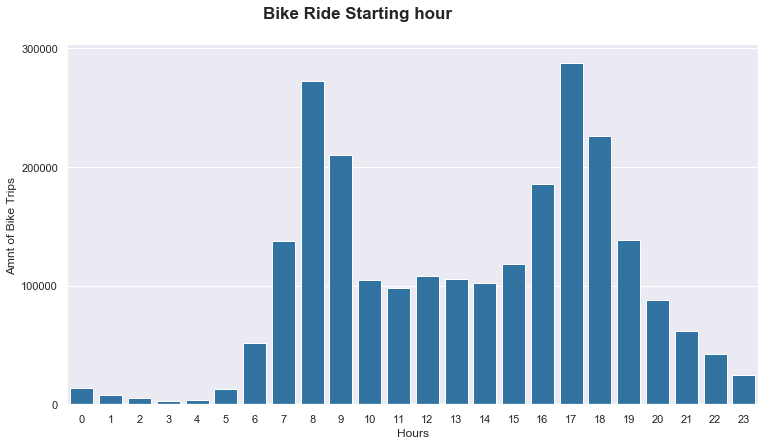

In [58]:
# plot boke ride histogramm for different hours
handle = sb.catplot(data=df, x='start_time_hour', kind='count', color = color_0)
plt.gcf().set_size_inches(12, 6)
handle.set_axis_labels("Hours", "Amnt of Bike Trips")
sb.set(font_scale=3.4)
handle.fig.suptitle('Bike Ride clustered for starting hour', y=1.05, fontsize=17, fontweight='semibold');

**observation:**
> It becomes aparant that the renting hours follow an U-Shape - indicating that a lot of people use the bike to get to work or to go out in the evening.

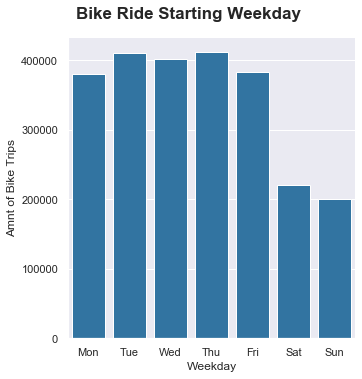

In [60]:
# plot boke ride histogramm for different weekdays
order_weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
handle = sb.catplot(data=df, x='start_time_weekday', kind='count', color = color_0, order = order_weekdays)
handle.set_axis_labels("Weekday", "Amnt of Bike Trips")
#sb.set(font_scale=1.0)
handle.fig.suptitle('Bike Ride clustered for weekdays', y=1.05, fontsize=17, fontweight='semibold');
plt.yticks([0, 100e3, 200e3, 300e3, 400e3]);


**observation**
> It becomes aparant that the renting is evenly distributed under the week and falls down over the weekend - indicating that people use the bikes to get to work.

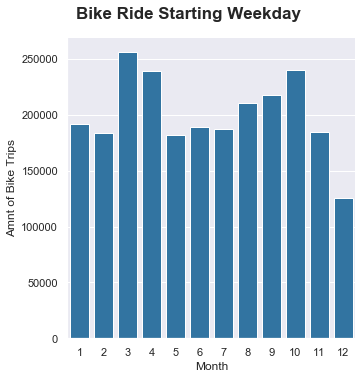

In [61]:
# plot boke ride histogramm for different months
handle = sb.catplot(data=df, x='start_time_month', kind='count', color = color_0)
handle.set_axis_labels("Month", "Amnt of Bike Trips")
#sb.set(font_scale=1.0)
handle.fig.suptitle('Bike Ride clustered for months', y=1.05, fontsize=17, fontweight='semibold');

**observation**
> It becomes aparant that the renting is spiking in Oktiber and April. This is unexpected, since I would expext some kind of plateu in the summer.

### Question 2:
*How long does the average trip take?*


### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

<a id='bivariate'></a>
## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

<a id='multivariate'></a>
## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!